In [1]:
%matplotlib inline

import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [17]:
FACE_MESH = pd.read_csv('..','faceMesh/face_mesh.csv')
def landmarks_mapper(video: str, data=0):
    """
    :Args:
    
    video : str
      Video to process landmark from
      Required.
    
    data : int, optional
      Type of data to be used :  
        0. Raw
        1. Cleansed  
        2. Interpolated
        Default to 0.
    """
    
    OPENFACE_LANDMARKS = [i for i in range(17, 68)]
    DATA = ['processed', 'processed_cleansed', 'processed_interpolated']
    
    if not(0 <= data <= 2):
        raise ValueError('data must be an int bewteen 0 and 2, extremes included')
    
    OPENFACE_DIR = f'../openFace/train/{DATA[data]}/'
    MEDIAPIPE_DIR = f'../mediaPipe/train/{DATA[data]}/'
    
    of_df = pd.read_csv(OPENFACE_DIR + video + '_openface.csv')
    mp_df = pd.read_csv(MEDIAPIPE_DIR + video + '_mediapipe.csv')
    
    final_df = of_df['frame'] # initialize the final dataframe
    for landmark in OPENFACE_LANDMARKS:

        mask = (FACE_MESH['openFace_landmark'] == landmark) # group the mediapipe landmarks by the openface landmark

        tmp1_df = of_df[[f'x_{landmark}', f'y_{landmark}']] # select the columns from the openface dataframe
        tmp1_df.columns = [f'openface_x_{landmark}', f'openface_y_{landmark}'] # rename the columns
        
        mediaPipe_landmarks_X = ['x_'+str(ID) for ID in FACE_MESH[mask].id] # collect the X coordinate
        mediaPipe_landmarks_Y = ['y_'+str(ID) for ID in FACE_MESH[mask].id] # collect the Y coordinate
        
        tmp2_df = pd.DataFrame({f'mediapipe_x_{landmark}':mp_df[mediaPipe_landmarks_X].mean(axis=1),
                                f'mediapipe_y_{landmark}':mp_df[mediaPipe_landmarks_Y].mean(axis=1)})
        
        final_df = pd.concat([final_df, tmp1_df, tmp2_df], axis=1)
        
    return final_df

# Pearson, R2 e CCC

In [11]:
def pearson(df: pd.DataFrame):
    
    lndmk_pearson = []
    for i in range(17, 68):
        
        x_pearson = pearsonr(df[f'openface_x_{i}'].to_numpy(), df[f'mediapipe_x_{i}'].to_numpy())[0]
        y_pearson = pearsonr(df[f'openface_y_{i}'].to_numpy(), df[f'mediapipe_y_{i}'].to_numpy())[0]
        lndmk_pearson.append((x_pearson+y_pearson)/2)
    
    video_pearson = np.mean(lndmk_pearson)
    
    return video_pearson

In [12]:
def mse(df: pd.DataFrame):
    
    lndmk_mse = []
    for i in range(17, 68):
        
        x_mse = mean_squared_error(df[f'mediapipe_x_{i}'].to_numpy(), df[f'openface_x_{i}'].to_numpy())
        y_mse = mean_squared_error(df[f'mediapipe_y_{i}'].to_numpy(), df[f'openface_y_{i}'].to_numpy())
        lndmk_mse.append((x_mse+y_mse)/2)
    
    video_mse = np.mean(lndmk_mse)
    
    return video_mse

In [13]:
def r2(df: pd.DataFrame):
    
    lndmk_r2 = []
    for i in range(17, 68):
        
        x_r2 = r2_score(df[f'mediapipe_x_{i}'].to_numpy(), df[f'openface_x_{i}'].to_numpy())
        y_r2 = r2_score(df[f'mediapipe_y_{i}'].to_numpy(), df[f'openface_y_{i}'].to_numpy())
        lndmk_r2.append((x_r2+y_r2)/2)
    
    video_r2 = np.mean(lndmk_r2)
    
    return video_r2

In [14]:
def rhoc(x,y):

    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    
    return rhoc

In [15]:
def ccc(df: pd.DataFrame):
    
    lndmk_ccc = []
    for i in range(17,68):
        
        x_ccc = rhoc(df[f'openface_x_{i}'].to_numpy(), df[f'mediapipe_x_{i}'].to_numpy())
        y_ccc = rhoc(df[f'openface_y_{i}'].to_numpy(), df[f'mediapipe_y_{i}'].to_numpy())
        lndmk_ccc.append((x_ccc+y_ccc)/2)
        
    video_ccc = np.mean(lndmk_ccc)
    
    return video_ccc

### Raw data

In [18]:
videos = []
videos_pearson = []
videos_mse = []
videos_r2 = []
videos_ccc = []
for video in os.listdir('../dataset/ElderReact_Data/ElderReact_train/'):
    video = video[:-4]
    videos.append(video)
    
    landmarks = landmarks_mapper(video, data=0)
    videos_pearson.append(pearson(landmarks))
    videos_mse.append(mse(landmarks))
    videos_r2.append(r2(landmarks))
    videos_ccc.append(ccc(landmarks))

extracted_features_df = pd.DataFrame({'video': videos, 'pearson': videos_pearson, 'mse': videos_mse, 'r2': videos_r2, 'ccc': videos_ccc})
%store extracted_features_df
extracted_features_df.to_csv('../dataframes/pearson_mse_r2_ccc.csv', index=False)
extracted_features_df

Stored 'extracted_features_df' (DataFrame)


,video,pearson,mse,r2,ccc
0,whack_your_boss_12,0.994934,9.000704,0.942965,0.973010
1,happy_wheels_54,0.982869,183.528720,0.947056,0.974094
2,would_you_rather_29,0.996148,15.811058,0.950094,0.976274
3,play_red_dead_138,0.843832,174.772622,0.535608,0.796104
4,Branda_schmitz_116,0.995152,21.042834,0.946881,0.974890
...,...,...,...,...,...
610,bully_burger_54,0.993915,11.461153,0.939585,0.971451
611,game_of_thrones_16,0.997744,10.053941,0.964062,0.982548
612,qwop_38,0.984438,41.346031,0.834824,0.932009
613,cuphead_58,0.992740,22.460664,0.948079,0.974823


### Cleansed data

In [19]:
videos = []
videos_pearson = []
videos_mse = []
videos_r2 = []
videos_ccc = []
for video in os.listdir('../dataset/ElderReact_Data/ElderReact_train/'):
    video = video[:-4]
    videos.append(video)
    
    landmarks = landmarks_mapper(video, data=1)
    videos_pearson.append(pearson(landmarks))
    videos_mse.append(mse(landmarks))
    videos_r2.append(r2(landmarks))
    videos_ccc.append(ccc(landmarks))

extracted_features_df_cleansed = pd.DataFrame({'video': videos, 'pearson': videos_pearson, 'mse': videos_mse, 'r2': videos_r2, 'ccc': videos_ccc})
%store extracted_features_df_cleansed
extracted_features_df_cleansed.to_csv('../dataframes/pearson_mse_r2_ccc_cleansed.csv', index=False)
extracted_features_df_cleansed

Stored 'extracted_features_df_cleansed' (DataFrame)


,video,pearson,mse,r2,ccc
0,whack_your_boss_12,0.994934,9.000704,0.942965,0.973010
1,happy_wheels_54,0.982869,183.528720,0.947056,0.974094
2,would_you_rather_29,0.996148,15.811058,0.950094,0.976274
3,play_red_dead_138,0.843832,174.772622,0.535608,0.796104
4,Branda_schmitz_116,0.995152,21.042834,0.946881,0.974890
...,...,...,...,...,...
610,bully_burger_54,0.993915,11.461153,0.939585,0.971451
611,game_of_thrones_16,0.997744,10.053941,0.964062,0.982548
612,qwop_38,0.984438,41.346031,0.834824,0.932009
613,cuphead_58,0.992740,22.460664,0.948079,0.974823


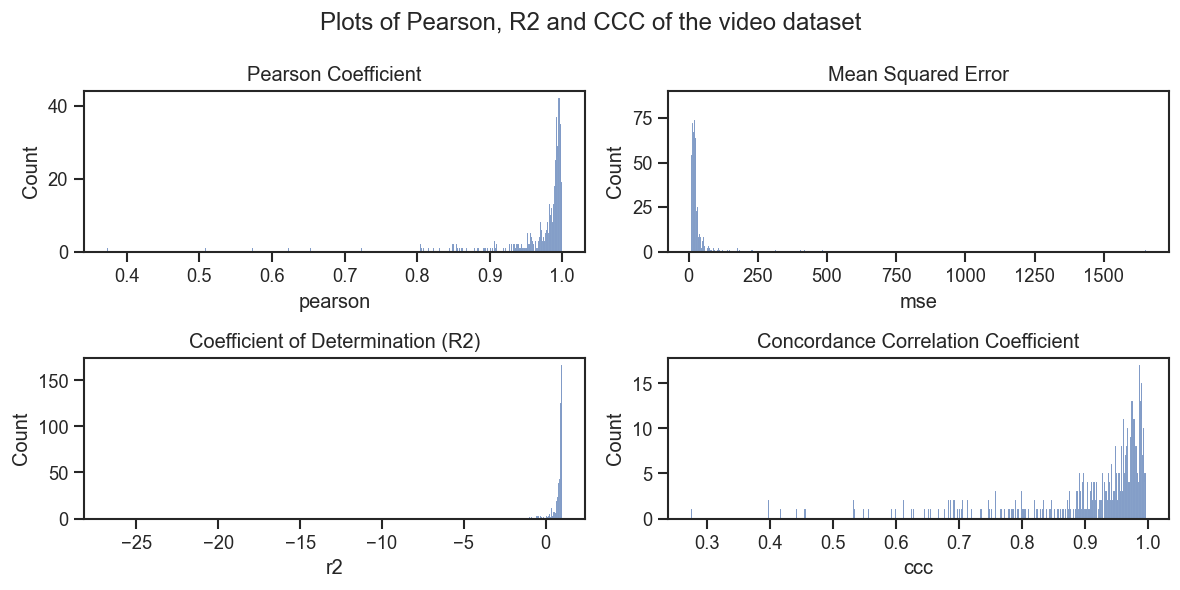

In [20]:
sns.set(rc={"figure.dpi":120})
sns.set_context('notebook')
sns.set_style("ticks")

fig, axes = plt.subplots(2,2, figsize=(10,5))
fig.suptitle('Plots of Pearson, R2 and CCC of the video dataset')
axes = axes.flatten()

# Pearson
axes[0].set_title('Pearson Coefficient')
sns.histplot(data=extracted_features_df_cleansed, x='pearson', bins=615, ax=axes[0])

# MSE
axes[1].set_title('Mean Squared Error')
sns.histplot(data=extracted_features_df_cleansed, x='mse', bins=615, ax=axes[1])

# R2
axes[2].set_title('Coefficient of Determination (R2)')
sns.histplot(data=extracted_features_df_cleansed, x='r2', bins=615, ax=axes[2])

# CCC
axes[3].set_title('Concordance Correlation Coefficient')
sns.histplot(data=extracted_features_df_cleansed, x='ccc', bins=615, ax=axes[3])

fig.tight_layout()
plt.show()

In [21]:
df = extracted_features_df_cleansed[extracted_features_df_cleansed.pearson < 0.8][['video', 'pearson']].sort_values(by='pearson')
videos_low_pearson = set(df['video'])
print('Numero di video con coefficiente di Pearson minore di 0.8:', len(df))
df

Numero di video con coefficiente di Pearson minore di 0.8: 8


,video,pearson
373,gta2_26,0.372666
186,david_bowie_13,0.508550
367,play_lastofus_202,0.572729
440,50_50_70,0.622576
96,happy_wheels_97,0.653155
136,TRY_NOT_LOOK_AWAY_21,0.692540
63,fatality_9,0.724319
318,dolan_dark_75,0.774172


In [22]:
df = extracted_features_df_cleansed[extracted_features_df_cleansed.mse > 50][['video', 'mse']].sort_values(by='mse')
videos_low_mse = set(df['video'])
print('Numero di video con MSE maggiore di 100:', len(df))
df

Numero di video con MSE maggiore di 100: 52


,video,mse
105,gta2_2,50.325532
602,happy_wheels_34,50.756963
155,gta1_46,50.786890
40,gta1_28,52.038689
323,qwop_21,52.093129
222,play_road_redemp_57,52.421765
39,happy_wheels_33,53.203585
179,happy_wheels_78,53.277336
364,happy_wheels_64,53.376353
513,happy_wheels_51,53.495691


In [23]:
df = extracted_features_df_cleansed[extracted_features_df_cleansed.r2 < 0.5][['video', 'r2']].sort_values(by='r2')
videos_low_r2 = set(df['video'])
print('Numero di video con R2 minore di 0.5:', len(df))
df

Numero di video con R2 minore di 0.5: 105


,video,r2
318,dolan_dark_75,-26.800569
136,TRY_NOT_LOOK_AWAY_21,-18.039448
493,50_50_77,-15.784128
367,play_lastofus_202,-6.728635
96,happy_wheels_97,-6.576062
...,...,...
330,japanese_show_85,0.470819
244,cuphead_21,0.471072
525,play_lastofus_165,0.477085
248,would_you_rather_19,0.481110


In [24]:
df = extracted_features_df_cleansed[extracted_features_df_cleansed.ccc < 0.8][['video', 'ccc']].sort_values(by='ccc')
videos_low_ccc = set(df['video'])
print('Numero di video con ccc minore di 0.8:', len(df))
df

Numero di video con ccc minore di 0.8: 88


,video,ccc
318,dolan_dark_75,0.273953
136,TRY_NOT_LOOK_AWAY_21,0.362971
493,50_50_77,0.396370
186,david_bowie_13,0.397103
85,play_road_redemp_49,0.415223
...,...,...
3,play_red_dead_138,0.796104
218,heartbeat_23,0.796468
173,godofwar_3,0.798098
84,play_lastofus_146,0.798122


In [25]:
videos_low_pearson.intersection(videos_low_r2).intersection(videos_low_ccc)

{'50_50_70',
 'TRY_NOT_LOOK_AWAY_21',
 'david_bowie_13',
 'dolan_dark_75',
 'fatality_9',
 'gta2_26',
 'happy_wheels_97',
 'play_lastofus_202'}

### Interpolated data

In [27]:
videos = []
videos_pearson = []
videos_mse = []
videos_r2 = []
videos_ccc = []
for video in os.listdir('../openFace/train/processed_interpolated/'):
    video = video[:-13]
    videos.append(video)
    
    landmarks = landmarks_mapper(video, data=2)
    videos_pearson.append(pearson(landmarks))
    videos_mse.append(mse(landmarks))
    videos_r2.append(r2(landmarks))
    videos_ccc.append(ccc(landmarks))

extracted_features_df_interpolated = pd.DataFrame({'video': videos, 'pearson': videos_pearson, 'mse': videos_mse, 'r2': videos_r2, 'ccc': videos_ccc})
%store extracted_features_df_interpolated
extracted_features_df_interpolated.to_csv('../dataframes/pearson_mse_r2_ccc_interpolated.csv', index=False)
extracted_features_df_interpolated

Stored 'extracted_features_df_interpolated' (DataFrame)


,video,pearson,mse,r2,ccc
0,fatality_2,0.998307,18.378170,0.970276,0.985659
1,flappy_bird_9,0.997258,18.455730,0.963264,0.982426
2,flappy_bird_14,0.995286,23.919627,0.944923,0.974579
3,would_you_rather_61,0.987945,21.147594,0.836772,0.927761
4,burnshoes_4,0.985226,14.623040,0.875300,0.947740
...,...,...,...,...,...
603,pewdiepie_165,0.991208,17.365920,0.943635,0.972858
604,fatality_5,0.999312,14.109765,0.968383,0.985041
605,happy_wheels_34,0.993141,37.171197,0.965189,0.982549
606,heartbeat_25,0.985630,15.072046,0.872029,0.948855


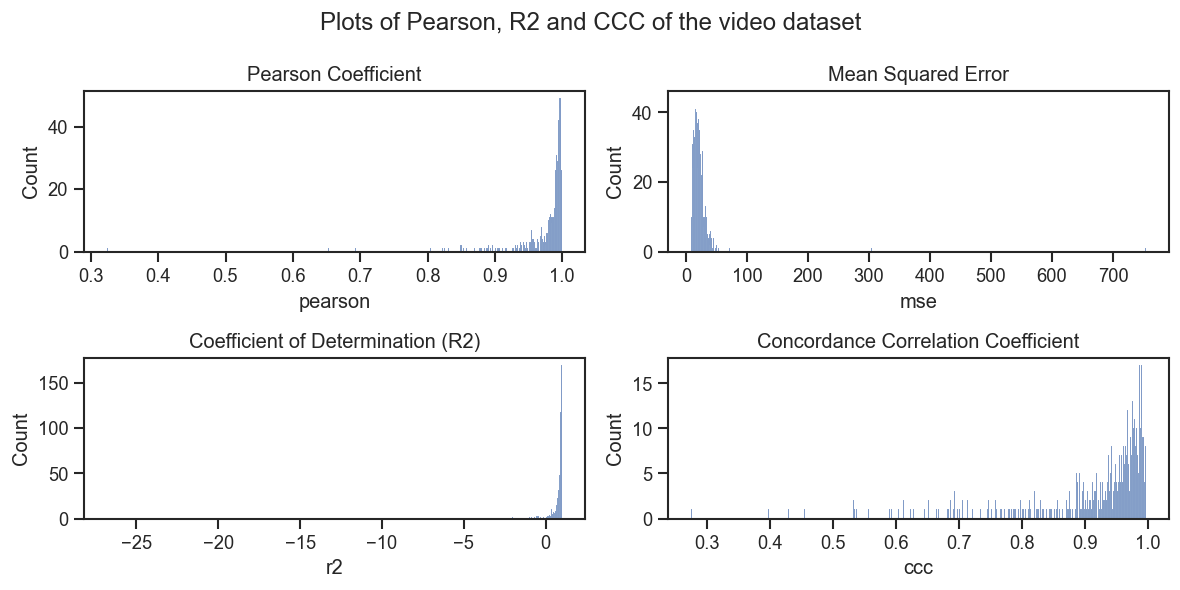

In [28]:
sns.set(rc={"figure.dpi":120})
sns.set_context('notebook')
sns.set_style("ticks")

fig, axes = plt.subplots(2,2, figsize=(10,5))
fig.suptitle('Plots of Pearson, R2 and CCC of the video dataset')
axes = axes.flatten()

# Pearson
axes[0].set_title('Pearson Coefficient')
sns.histplot(data=extracted_features_df_interpolated, x='pearson', bins=615, ax=axes[0])

# MSE
axes[1].set_title('Mean Squared Error')
sns.histplot(data=extracted_features_df_interpolated, x='mse', bins=615, ax=axes[1])

# R2
axes[2].set_title('Coefficient of Determination (R2)')
sns.histplot(data=extracted_features_df_interpolated, x='r2', bins=615, ax=axes[2])

# CCC
axes[3].set_title('Concordance Correlation Coefficient')
sns.histplot(data=extracted_features_df_interpolated, x='ccc', bins=615, ax=axes[3])

fig.tight_layout()
plt.show()

In [29]:
%store -r extracted_features_df_cleansed
%store -r extracted_features_df_interpolated

print('MSE before interpolation:', extracted_features_df_cleansed.mse.mean())
print('MSE after interpolation:', extracted_features_df_interpolated.mse.mean())

MSE before interpolation: 34.68571075373996
MSE after interpolation: 23.64353553603304


In [30]:
df = extracted_features_df_interpolated[extracted_features_df_interpolated.pearson < 0.8][['video', 'pearson']].sort_values(by='pearson')
videos_low_pearson = set(df['video'])
print('Numero di video con coefficiente di Pearson minore di 0.8:', len(df))
df

Numero di video con coefficiente di Pearson minore di 0.8: 5


,video,pearson
289,gta2_26,0.323948
405,50_50_70,0.652438
100,TRY_NOT_LOOK_AWAY_21,0.692540
73,qwop_39,0.719280
499,dolan_dark_75,0.774172


In [31]:
df = extracted_features_df_interpolated[extracted_features_df_interpolated.mse > 50][['video', 'mse']].sort_values(by='mse')
videos_low_mse = set(df['video'])
print('Numero di video con MSE maggiore di 100:', len(df))
df

Numero di video con MSE maggiore di 100: 10


,video,mse
128,qwop_48,50.337307
517,happy_wheels_91,50.384806
428,david_bowie_13,52.043838
547,happy_wheels_51,53.495691
484,gta2_2,70.288572
421,Branda_schmitz_52,84.512095
203,fatality_6,257.090104
49,50_50_4,303.793669
204,50_50_61,378.290579
289,gta2_26,754.148642


In [32]:
df = extracted_features_df_interpolated[extracted_features_df_interpolated.r2 < 0.5][['video', 'r2']].sort_values(by='r2')
videos_low_r2 = set(df['video'])
print('Numero di video con R2 minore di 0.5:', len(df))
df

Numero di video con R2 minore di 0.5: 101


,video,r2
499,dolan_dark_75,-26.800569
100,TRY_NOT_LOOK_AWAY_21,-18.039448
52,50_50_77,-15.784128
385,50_50_68,-4.602246
289,gta2_26,-4.327094
...,...,...
160,cuphead_21,0.471072
396,david_bowie_36,0.471992
497,play_lastofus_165,0.477085
184,would_you_rather_19,0.481110


In [33]:
df = extracted_features_df_interpolated[extracted_features_df_interpolated.ccc < 0.8][['video', 'ccc']].sort_values(by='ccc')
videos_low_ccc = set(df['video'])
print('Numero di video con ccc minore di 0.8:', len(df))
df

Numero di video con ccc minore di 0.8: 78


,video,ccc
499,dolan_dark_75,0.273953
100,TRY_NOT_LOOK_AWAY_21,0.362971
52,50_50_77,0.396370
289,gta2_26,0.428981
73,qwop_39,0.452890
...,...,...
126,play_lastofus_82,0.792289
224,gta2_29,0.793643
453,heartbeat_23,0.796468
118,godofwar_3,0.798098


In [34]:
videos_low_pearson.intersection(videos_low_r2).intersection(videos_low_ccc)

{'50_50_70', 'TRY_NOT_LOOK_AWAY_21', 'dolan_dark_75', 'gta2_26', 'qwop_39'}